# ***KÜTÜPHANELER***


In [ ]:
!pip install google-cloud-speech #ses dosyasından text çıkartmak için

In [ ]:
!pip install noisereduce #gürültü azaltma

In [ ]:
import os
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from google.cloud import speech_v1p1beta1 as speech
from google.colab import files
import numpy as np
import noisereduce as nr
import soundfile as sf


In [ ]:
#Çalışma dizinini değiştirme
def set_working_directory(path):
    os.chdir(path)
    print(f"Çalışma dizini değiştirildi: {os.getcwd()}")

# Kullanım
set_working_directory('/content')  # Ana dizine git

#İçinde bulunulan ana dizin
print(f"İçerisinde bulunulan ana dizin: {os.getcwd()}")


Çalışma dizini değiştirildi: /content
İçerisinde bulunulan ana dizin: /content


# ***Ses Dosyasını Yükleme ve Temel İşlemler***

In [ ]:
# Ses dosyasını yükleme
uploaded = files.upload()

Saving audio.wav to audio.wav


In [ ]:
# Ses dosyası
audio_path = '/content/audio.wav'
y, sr = librosa.load(audio_path, sr=16000)  # sr: örnekleme hızı (16kHz standart)
print(f"Yüklenen Sesin Boyutu: {len(y)}, Örnekleme Hızı: {sr}")


Yüklenen Sesin Boyutu: 830805, Örnekleme Hızı: 16000


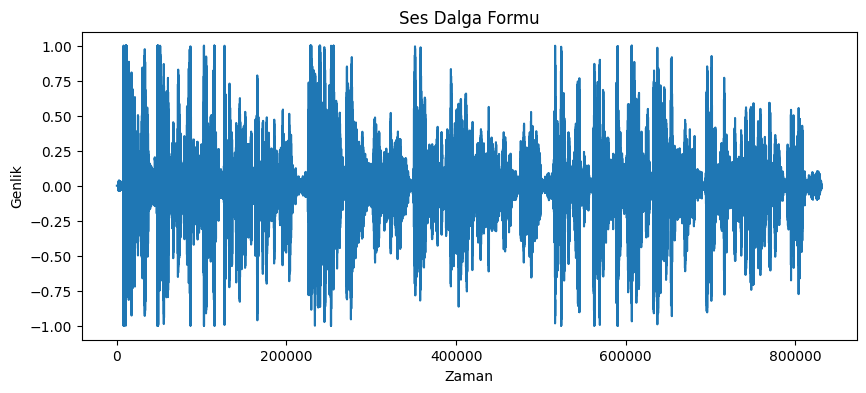

In [ ]:
# Ses dalgası
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title("Ses Dalga Formu")
plt.xlabel("Zaman")
plt.ylabel("Genlik")
plt.show()


In [ ]:
Audio(audio_path) # sesi doğrudan hücrede çalmak

# ***Gürültü Azaltma***

In [ ]:
# Enerjiyi hesabı
frame_length = 4096 # ya da n_fft olarak
hop_length = 1024
energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
silence_threshold = 0.01  # Eşik değer

# Sessiz bölge kontrolü
silent_frames = np.where(energy < silence_threshold)[0]
if len(silent_frames) == 0:
    raise ValueError("Sessiz bölge bulunamadı, eşik değerini kontrol edin!")

# Gürültü örneği seçimi
noise_sample = y[silent_frames[0]:silent_frames[0] + int(sr * 1)]
if len(noise_sample) < sr * 1:
    raise ValueError("Gürültü örneği çok kısa, eşik değerini kontrol edin!")


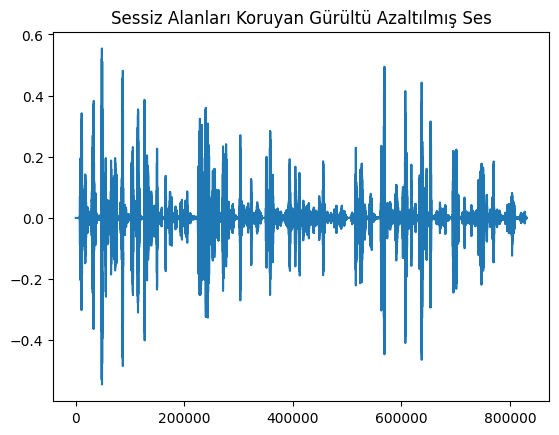

In [ ]:
#n_fft = 2048       # Segment uzunluğu (nperseg)
#hop_length = 512   # İlerleme miktarı (noverlap etkilenir)

if hop_length >= frame_length:
    raise ValueError("hop_length must be less than n_fft.")


# Gürültü azalt ama sessiz alanları koru
y_denoised = nr.reduce_noise(
    y=y,
    sr=sr,
    y_noise=noise_sample,
    stationary=True,
  #  n_fft=2048,        # Segment uzunluğu
  #  hop_length=512     # İlerleme miktarı (nperseg > hop_length)
)

# Sessizlik bölgeleri harici tam sinyal
plt.plot(y_denoised)
plt.title("Sessiz Alanları Koruyan Gürültü Azaltılmış Ses")
plt.show()


In [ ]:
# İşlenen sesi dinle
Audio(y_denoised, rate=sr)

***Ses genliğini yükseltmek***

In [ ]:
# Maksimum genliğe göre normalize et
y_denoised = y_denoised / np.max(np.abs(y_denoised))

# Ses seviyesini artırmak için bir katsayı ile çarp
amplification_factor = 5  # 1.0 = orijinal ses, 1.5 = %50 artış
y_amplified = y_denoised * amplification_factor

# Clipping kontrolü: Genlik [-1, 1] aralığını aşarsa kıs
y_amplified = np.clip(y_amplified, -1, 1)

# İşlenmiş ses
Audio(y_amplified, rate=sr)


In [ ]:
# Ses kaydı
sf.write('onlyspeech.wav', y_amplified, sr)

print("Ses dosyası 'onlyspeech.wav' olarak kaydedildi.")

Ses dosyası 'onlyspeech.wav' olarak kaydedildi.


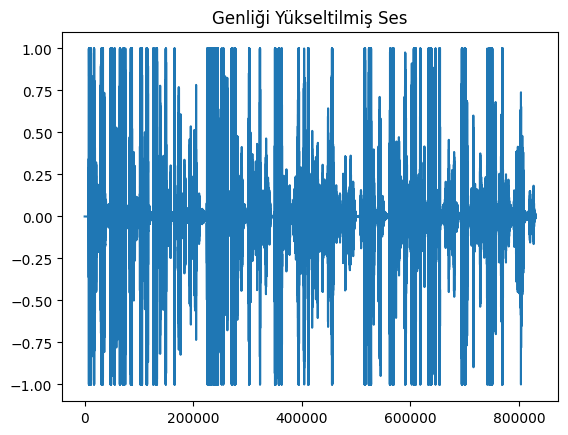

In [ ]:
# Genliği Yükseltilmiş Ses
plt.plot(y_amplified)
plt.title("Genliği Yükseltilmiş Ses")
plt.show()


# ***Ses Dosyası Temel Analizler***

In [ ]:
duration = librosa.get_duration(y=y, sr=sr)
print(f"Ses Dosyasının Süresi: {duration:.2f} saniye")


Ses Dosyasının Süresi: 51.93 saniye


In [ ]:
# Sessiz alanları bul
non_silent_intervals = librosa.effects.split(y, top_db=30)  # Sessizlik eşiği
print(f"Non-sessiz Bölgeler: {non_silent_intervals}")
print(f"Duraksama Sayısı: {len(non_silent_intervals)}")


Non-sessiz Bölgeler: [[  2560   5120]
 [  6656 506368]
 [506880 558592]
 [559104 691200]
 [693760 830464]]
Duraksama Sayısı: 5


## ***Diksiyon Analizi İçin Özellik Çıkartma***

**Google Speech-to-text ile ses dosyasının transkriptini alma**

In [ ]:
# Kimlik doğrulama dosyası
uploaded = files.upload()  # JSON dosyanı buradan yükle

# Eğer speech-to-text kullanacaksanız kendi .json dosyanızı buraya yukleyin
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/sesdosyanızınyolu.json"

# Google Speech-to-Text istemcisini başlat
client = speech.SpeechClient()

uploaded_audio = files.upload()  # Ses dosyanı yükle

audio_file_path = list(uploaded_audio.keys())[0]

# Ses dosyasını Google API'ye göndermek için formatla
with open(audio_file_path, "rb") as audio_file:
    audio_content = audio_file.read()

audio = speech.RecognitionAudio(content=audio_content)

# Konfigürasyon ayarları
config = speech.RecognitionConfig(
    encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
    sample_rate_hertz=16000,
    language_code="tr-TR"  # Türkçe için dil kodu
)

# API'yi çağırarak sonucu al
response = client.recognize(config=config, audio=audio)

# sonuçlar
for result in response.results:
    print("Transkript:", result.alternatives[0].transcript)

Saving sunumdiksiyon-f4d662c20f42.json to sunumdiksiyon-f4d662c20f42.json


Saving audio.wav to audio (1).wav
Transkript: geçen sene Eylül'de bütün dünya sallandı deprem direktörlerin hissettiği Sarsıntı çok kahve içmiş bir ne titreyen ellerinden daha şiddetliydi Ama insanların hissedebileceği bir seviyede değil de bu garip titreşim 9 gün sürdü sismologlar şaşkındı yüksek frekanslı değildi Daha ziyade monoton bir uğultu gibiydi sinir bozucu bir komşunun çim biçme makinesini düşünür her 90 saniyede birileri bilim insanları önce sebebin ne olduğunu Bulamadı bu yüzden durma tanımlanamayan Sismik isim adını verdi ama en sonunda nedenini buldular sebep grönland'ın doğusundaki bir Mega Tsunami 710 Mısır büyüklüğündeki Kaya ve bozulmuş yoğurtlardan denize düştüğünü hayalet parçalanma sebebi tahmin edileceği gibi küresel iklim değişikliği di parçalanma 200 metrelik Tsunami eve Dünyamız salgılanmasına sebep olan sarsıntıya yol açtı İyi ki orada kimse yaşamıyor


***Uzun Duraksamlar***

In [ ]:
# Sessiz alan tespiti
silent_intervals = librosa.effects.split(y, top_db=30)

# Ses dosyasının toplam süresi
total_duration = librosa.get_duration(y=y, sr=sr)

# Orta kısmı filtreleme: Baş ve son sessiz alanları hariç tut
filtered_silent_intervals = [
    (start, end) for start, end in silent_intervals
    if start / sr > 1 and end / sr < (total_duration - 1)  # 1 saniyelik baş ve son toleransı
]

# Uzun sessiz alanları tespit et (örneğin, 1 saniyeden uzun olanlar)
long_silences = [(start / sr, end / sr) for start, end in filtered_silent_intervals if (end - start) / sr > 1]

# Sonuçlar
print("Uzun Duraksamalar (Ortalarda):")
for silence in long_silences:
    print(f"Başlangıç: {silence[0]:.2f} saniye, Bitiş: {silence[1]:.2f} saniye, Süre: {silence[1] - silence[0]:.2f} saniye")


Uzun Duraksamalar (Ortalarda):
Başlangıç: 10.17 saniye, Bitiş: 13.24 saniye, Süre: 3.07 saniye
Başlangıç: 13.63 saniye, Bitiş: 15.53 saniye, Süre: 1.90 saniye
Başlangıç: 15.86 saniye, Bitiş: 17.23 saniye, Süre: 1.37 saniye
Başlangıç: 17.44 saniye, Bitiş: 18.88 saniye, Süre: 1.44 saniye
Başlangıç: 26.68 saniye, Bitiş: 29.77 saniye, Süre: 3.09 saniye
Başlangıç: 32.28 saniye, Bitiş: 34.44 saniye, Süre: 2.16 saniye


Sessiz alanları bir zaman ekseninde görselleştirmek

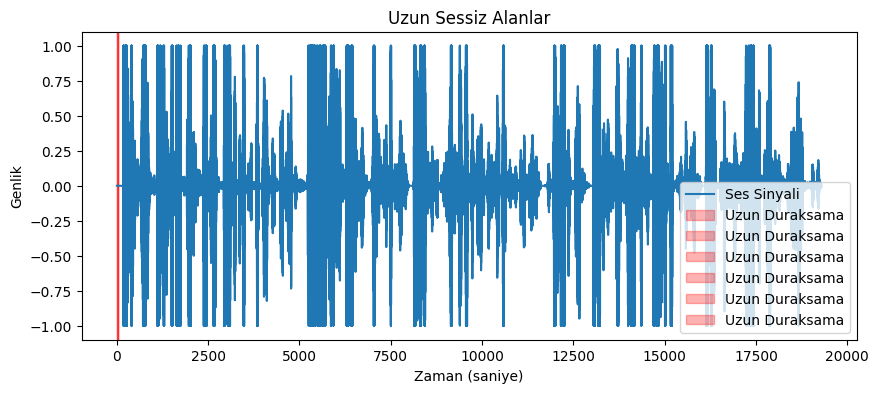

In [ ]:
# Zaman ekseni
t = librosa.times_like(y, sr=sr)

# Sessiz alanları göster
plt.figure(figsize=(10, 4))
plt.plot(t, y, label="Ses Sinyali")
for start, end in long_silences:
    plt.axvspan(start, end, color='red', alpha=0.3, label="Uzun Duraksama")
plt.title("Uzun Sessiz Alanlar")
plt.xlabel("Zaman (saniye)")
plt.ylabel("Genlik")
plt.legend()
plt.show()


***Konuşma Hızı Hesabı(Dakika başına kelime sayısı - WPM)***


In [ ]:
# Ses dosyasının süresi
def get_audio_duration(audio_path):
    duration = librosa.get_duration(filename=audio_path)
    return duration

# Google Speech-to-Text ile metin alma
def transcribe_audio(audio_path):
    client = speech.SpeechClient()
    with open(audio_path, "rb") as audio_file:
        audio_content = audio_file.read()

    audio = speech.RecognitionAudio(content=audio_content)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=16000,
        language_code="tr-TR"  # Türkçe dil kodu
    )

    response = client.recognize(config=config, audio=audio)
    transcript = " ".join([result.alternatives[0].transcript for result in response.results])
    return transcript

# Konuşma hızını hesapla
def calculate_speech_speed(audio_path):
    # Ses süresi
    duration = get_audio_duration(audio_path)

    # Transkript
    transcript = transcribe_audio(audio_path)
    word_count = len(transcript.split())  # Kelime sayısı

    # WPM hesabı
    wpm = (word_count * 60) / duration
    return word_count, duration, wpm

*Tüm ses dosyası için*

In [ ]:
audio_file_path = audio_path

# Hesaplama
word_count, duration, wpm = calculate_speech_speed(audio_file_path)
print(f"Kelime Sayısı: {word_count}")
print(f"Ses Süresi: {duration:.2f} saniye")
print(f"Ortalama Konuşma Hızı: {wpm:.2f} WPM")

<ipython-input-20-4c8614f7b65a>:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)


Kelime Sayısı: 117
Ses Süresi: 51.93 saniye
Ortalama Konuşma Hızı: 135.19 WPM


*Sadece konuşma alanındaki süre zarfınca*

In [ ]:
def get_speech_duration(audio_path, silence_threshold=25):

    # Sessiz alan tespiti
    non_silent_intervals = librosa.effects.split(y, top_db=silence_threshold)

    # Konuşma süresi hesabı
    speech_duration = sum((end - start) for start, end in non_silent_intervals) / sr
    return speech_duration


# audio_path - Daha önce yüklenen ses dosyasının yolu
speech_duration = get_speech_duration(audio_path)
print(f"Sadece konuşma süresi: {speech_duration:.2f} saniye")

# Konuşma hızını güncelleyerek yeniden hesapla
word_count, _, wpm = calculate_speech_speed(audio_path)
updated_wpm = (word_count * 60) / speech_duration
print(f"Sessiz alanlar hariç ortalama konuşma hızı: {updated_wpm:.2f} WPM")


Sadece konuşma süresi: 48.90 saniye


<ipython-input-20-4c8614f7b65a>:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)


Sessiz alanlar hariç ortalama konuşma hızı: 143.57 WPM


Optimum Konuşma Hızını Seçmek:
  1. Anlaşılabilirlik öncelikli ise: 120-150 WPM.
  2. Enerjik ve motive edici bir etki isteniyorsa: 150-180 WPM.
  3. Teknik ve ağır içerikler için: 110-130 WPM.


***Ses Tonu (Pitch) Analizi***

In [ ]:
pitch = librosa.yin(y, fmin=50, fmax=300, sr=sr)  # Tipik insan sesi aralığı (Hz)
avg_pitch = np.mean(pitch)
print(f"Ortalama Ses Frekansı (Pitch): {avg_pitch:.2f} Hz")


Ortalama Ses Frekansı (Pitch): 119.18 Hz


***RMS (Root Mean Square)***
>Ses analizinde sıkça kullanılan RMS, genellikle ses sinyalinin enerjisini veya genliğini temsil etmek için kullanılır. Bu, bir sinyalin ne kadar "güçlü" olduğunu anlamaya yardımcı olur.
>
>*RMS Ses Analizinde Ne Anlama Gelir?*
1. Ses Gücü: RMS, bir ses sinyalinin genel gücünü ölçmek için kullanılır. Daha yüksek RMS değerleri, daha güçlü veya daha yüksek sesli bir sinyal anlamına gelir.
2. Dinamik Aralık: RMS, ses sinyalinin dinamik aralığını analiz etmek için faydalıdır.
3. Gürültü Seviyesi: Sesin enerji seviyesini değerlendirerek gürültü ölçümünde kullanılabilir.



In [ ]:
# Ses dosyası
y, sr = librosa.load(audio_path)

# RMS hesaplama
rms = librosa.feature.rms(y=y)
print("RMS Değerleri:", rms)

# Ortalama RMS
mean_rms = np.mean(rms)
print(f"Ortalama RMS: {mean_rms}") #genlik (amplitude) ölçüsüdür ve genellikle birim içermez

RMS Değerleri: [[0.0000000e+00 1.8879721e-13 2.6762777e-13 ... 1.4138423e-02
  1.2175391e-02 1.0346660e-02]]
Ortalama RMS: 0.10153525322675705


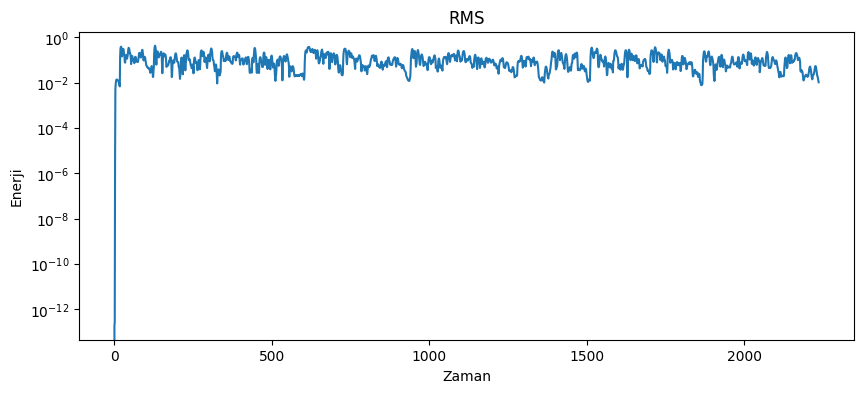

In [ ]:
plt.figure(figsize=(10, 4))
plt.semilogy(rms.T, label='RMS Enerji')
plt.title("RMS")
plt.xlabel("Zaman")
plt.ylabel("Enerji")
plt.show()


>*Yüksek RMS (Enerjik Sinyal)*
- Tipik konuşma için RMS: 0.01 - 0.03 aralığında olabilir.
- Gürültülü bir ses veya müzik için RMS: 0.1 ve üzeri.
>
>*Düşük RMS (Sessiz veya Zayıf Sinyal)*
- Tipik konuşma için RMS: 0.001 - 0.01 aralığında olabilir.
- Sessiz bölgeler veya arka plan gürültüsü: 0.0001 veya daha düşük.


***Ses Yüksekliği (Volume dB)***
>Konuşma Ses Seviyeleri
1. Ortalama Konuşma (50-70 dB):
Normal bir konuşma sırasında üretilen ses seviyesidir.
Çoğu insan bu aralıkta rahat bir şekilde konuşur ve dinler.
2. Yüksek Sesle Konuşma (70-85 dB):
Daha enerjik, vurgulu veya dikkat çekici konuşmalar bu seviyede olabilir.
Kalabalık bir ortamda konuşma sırasında tipik olarak bu aralığa ulaşılır.
3. Sessiz Konuşma (30-50 dB):
Fısıltı veya özel bir konuşma sırasında ses seviyeleri bu aralıktadır.
>
>- 0-30 dB: Sessiz alanlar (fısıltı, sakin ortamlar).
- 30-70 dB: Konuşma ve günlük ortam sesleri.
- 70-90 dB: Gürültülü ortamlar (trafik, kalabalık).
- 90+ dB: Rahatsız edici ve işitme kaybı riski taşıyan sesler.

In [ ]:
y, sr = librosa.load(audio_path)


y = y / np.max(np.abs(y))  # Sinyali normalleştir

# RMS (karekök ortalama) ile ses enerjisi hesaplama
rms = librosa.feature.rms(y=y)[0]

# Desibel (dB) dönüşümü
volume_db = 20 * np.log10(rms + 1e-6)  # Küçük bir değer ekleyerek log(0) hatasını önlüyoruz

# Ortalama ses yüksekliği
mean_volume = np.mean(volume_db)
print(f"Ortalama Ses Yüksekliği: {mean_volume:.2f} dB")

Ortalama Ses Yüksekliği: -22.95 dB


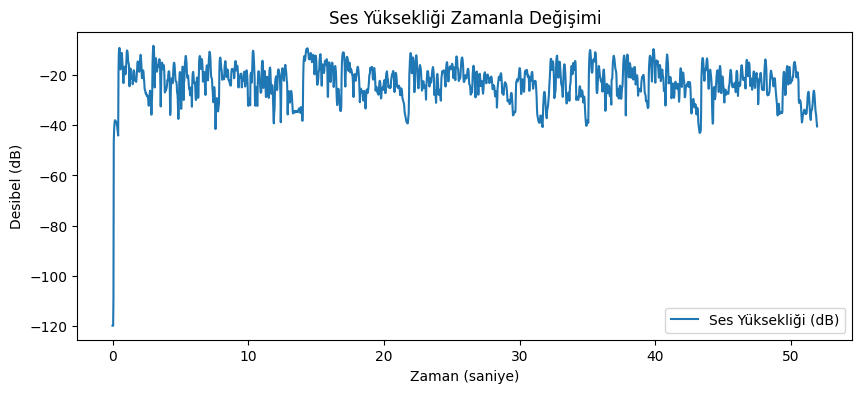

In [ ]:
# Zaman bilgisi oluştur
frames = range(len(volume_db))
t = librosa.frames_to_time(frames, sr=sr)

# Ses yüksekliği grafiği
plt.figure(figsize=(10, 4))
plt.plot(t, volume_db, label="Ses Yüksekliği (dB)")
plt.title("Ses Yüksekliği Zamanla Değişimi")
plt.xlabel("Zaman (saniye)")
plt.ylabel("Desibel (dB)")
plt.legend()
plt.show()


***Spektral Kütle Merkezi (Spectral Centroid)***
> Spektral Kütle Merkezi, bir ses sinyalinin frekans spektrumunun ağırlık merkezini temsil eder. Daha basit bir ifadeyle, sesin "parlaklık" veya "tizlik" seviyesini ölçer. Spektral Kütle Merkezi bir sinyalde yüksek frekansların ne kadar baskın olduğunu anlamak için kullanılır.
- Düşük Spectral Centroid: Daha fazla düşük frekans içerir, "bas" ağırlıklı sesler. (Örneğin, erkek sesi veya davul gibi düşük frekanslı sesler).
- Yüksek Spectral Centroid: Daha fazla yüksek frekans içerir, "tiz" ağırlıklı sesler. (Örneğin, kadın sesi veya zil sesi gibi yüksek frekanslı sesler).


Ortalama Spectral Centroid: 1965.11 Hz


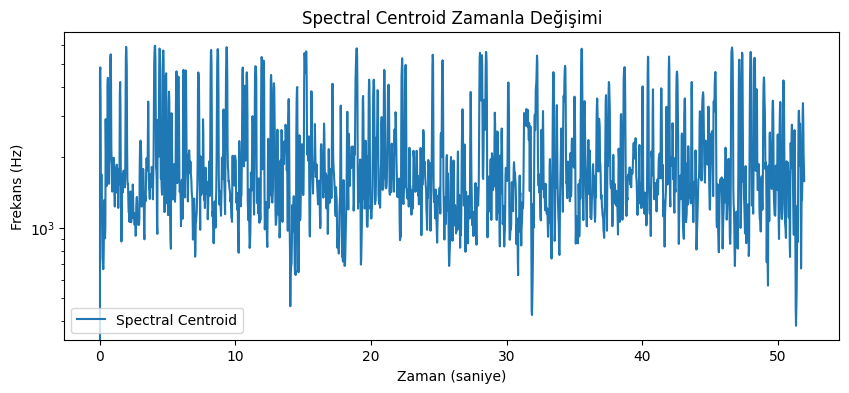

In [ ]:
y, sr = librosa.load(audio_path)

# Spectral Centroid hesaplama
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

# Ortalama Spectral Centroid
mean_centroid = np.mean(spectral_centroids)
print(f"Ortalama Spectral Centroid: {mean_centroid:.2f} Hz")

# Zaman ekseninde görselleştirme
import matplotlib.pyplot as plt
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames, sr=sr)

plt.figure(figsize=(10, 4))
plt.semilogy(t, spectral_centroids, label='Spectral Centroid')
plt.xlabel('Zaman (saniye)')
plt.ylabel('Frekans (Hz)')
plt.title('Spectral Centroid Zamanla Değişimi')
plt.legend()
plt.show()


>Değerin Normal Olup Olmadığını Belirlemek
Spectral centroid'in normal olup olmadığını belirlemek için sesin türünü bilmek önemlidir:
>
>Konuşma Sesleri:
>
> - Erkek sesi için: Ortalama 1500-2000 Hz aralığında olabilir.
-Kadın sesi için: Ortalama 2000-3000 Hz aralığında olabilir.
- Çocuk sesi: Daha yüksek, genellikle 3000 Hz üzeri.
>
>Müzik ve Enstrümanlar:
>
> - Düşük frekanslı enstrümanlar (örneğin, bas gitar veya davul): 500-1500 Hz.
> - Orta frekanslı enstrümanlar (örneğin, piyano): 1000-3000 Hz.
> - Yüksek frekanslı enstrümanlar (örneğin, keman, flüt): 3000 Hz ve üzeri.

___________________________________________________________________________
Sesin frekans dağılımını görselleştirerek spectral centroid'in bu dağılıma uygun olup olmadığı kontrol edilebilir.

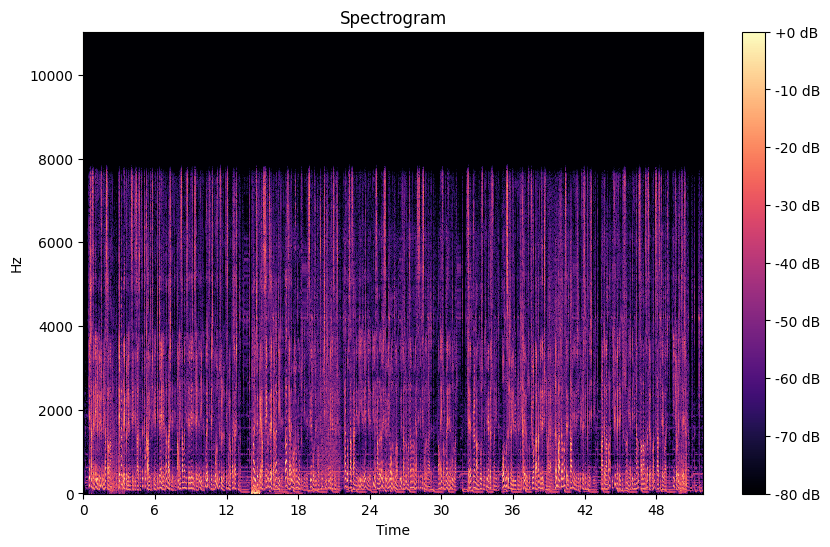

In [ ]:
S = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

_________________________________________
Spectral centroid değerlerini histogram üzerinde dağıtarak ses türüyle uyumu analiz edilebilir.

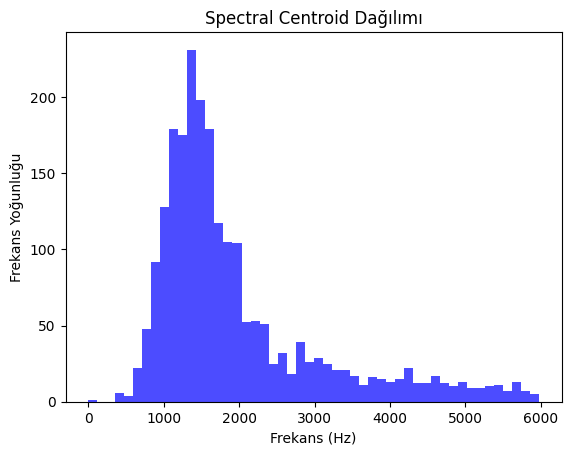

In [ ]:
plt.hist(spectral_centroids, bins=50, color='blue', alpha=0.7)
plt.title("Spectral Centroid Dağılımı")
plt.xlabel("Frekans (Hz)")
plt.ylabel("Frekans Yoğunluğu")
plt.show()


Spectral centroid'in ortalama ve standart sapma değerlerini hesaplayarak beklenen aralıkta olup olmadığını kontrol edin :

In [ ]:
mean_centroid = np.mean(spectral_centroids)
std_centroid = np.std(spectral_centroids)
print(f"Ortalama: {mean_centroid:.2f}, Standart Sapma: {std_centroid:.2f}")


Ortalama: 1965.11, Standart Sapma: 1119.68


 ***Spektral Dönüşüm Frekansı (Spectral Rolloff)***
 >Bir ses sinyalinin spektrumunun toplam enerji yoğunluğunun belirli bir yüzdesini (genellikle %85) içerdiği frekansı ifade eder. Bu metrik, bir sesin "parlaklık" seviyesini ölçmek veya düşük frekans ve yüksek frekans bileşenlerini ayırt etmek için kullanılır.

Ortalama Spectral Rolloff: 3822.56 Hz


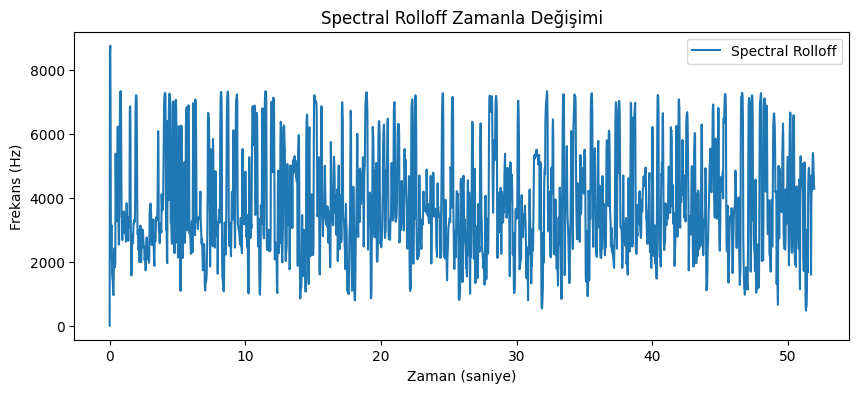

In [ ]:
y, sr = librosa.load(audio_path)

# Spectral rolloff hesaplama
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]

# Ortalama rolloff
mean_rolloff = np.mean(rolloff)
print(f"Ortalama Spectral Rolloff: {mean_rolloff:.2f} Hz")

# Görselleştirme
import matplotlib.pyplot as plt
frames = range(len(rolloff))
t = librosa.frames_to_time(frames, sr=sr)

plt.figure(figsize=(10, 4))
plt.plot(t, rolloff, label="Spectral Rolloff")
plt.title("Spectral Rolloff Zamanla Değişimi")
plt.xlabel("Zaman (saniye)")
plt.ylabel("Frekans (Hz)")
plt.legend()
plt.show()

Spectral rolloff değerlerinin dağılımını analiz etmek için bir histogram

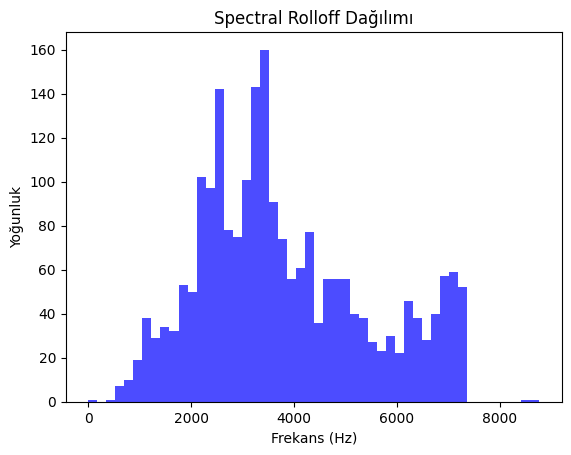

In [ ]:
plt.hist(rolloff, bins=50, color='blue', alpha=0.7)
plt.title("Spectral Rolloff Dağılımı")
plt.xlabel("Frekans (Hz)")
plt.ylabel("Yoğunluk")
plt.show()


***Ortalama Enerjisini (energy_mean)***
>Ses sinyalinin ortalama enerjisini (energy_mean) hesaplamak, konuşmanın genel yoğunluğunu ve enerji seviyesini anlamak için oldukça faydalıdır. Ortalama enerji, genellikle sinyalin RMS (Root Mean Square) değerlerinin ortalaması alınarak hesaplanır.

In [ ]:
y, sr = librosa.load(audio_path)

# RMS (Root Mean Square) enerjisi hesapla
rms = librosa.feature.rms(y=y)[0]

# Ortalama enerji
energy_mean = np.mean(rms)
print(f"Ortalama Enerji: {energy_mean:.6f}")

Ortalama Enerji: 0.101535


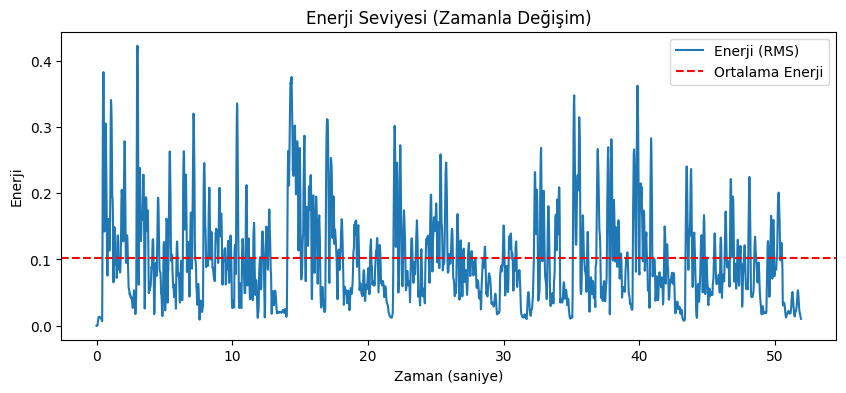

In [ ]:
# Zaman ekseni
frames = range(len(rms))
t = librosa.frames_to_time(frames, sr=sr)

# RMS grafiği
plt.figure(figsize=(10, 4))
plt.plot(t, rms, label="Enerji (RMS)")
plt.axhline(y=energy_mean, color='r', linestyle='--', label="Ortalama Enerji")
plt.title("Enerji Seviyesi (Zamanla Değişim)")
plt.xlabel("Zaman (saniye)")
plt.ylabel("Enerji")
plt.legend()
plt.show()

Enerji Eşiklerine Göre Kategorize Etme:

>Enerji seviyelerini analiz ederek "yüksek enerji", "düşük enerji" ve "sessiz alanlar" olarak sınıflandırabilirsiniz:

In [ ]:
high_energy = rms[rms > 0.2]
low_energy = rms[(rms <= 0.2) & (rms > 0.05)]
silent = rms[rms <= 0.05]
print(f"Yüksek Enerji Segmentleri: {len(high_energy)}")
print(f"Düşük Enerji Segmentleri: {len(low_energy)}")
print(f"Sessiz Segmentler: {len(silent)}")


Yüksek Enerji Segmentleri: 225
Düşük Enerji Segmentleri: 1452
Sessiz Segmentler: 560


Sessiz, düşük ve yüksek enerji bölgelerini grafikte farklı renklerle göstermek faydalı olabilir:

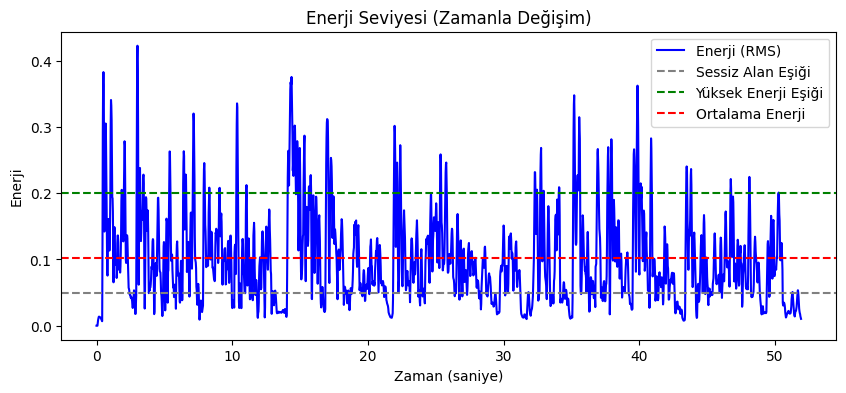

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t, rms, label="Enerji (RMS)", color="blue")
plt.axhline(y=0.05, color='gray', linestyle='--', label="Sessiz Alan Eşiği")
plt.axhline(y=0.2, color='green', linestyle='--', label="Yüksek Enerji Eşiği")
plt.axhline(y=energy_mean, color='red', linestyle='--', label="Ortalama Enerji")
plt.title("Enerji Seviyesi (Zamanla Değişim)")
plt.xlabel("Zaman (saniye)")
plt.ylabel("Enerji")
plt.legend()
plt.show()


Sessiz alanlar harici ortalama enerji bulma:

In [ ]:
non_silent_intervals = librosa.effects.split(y, top_db=30)
y_non_silent = np.concatenate([y[start:end] for start, end in non_silent_intervals])
rms_non_silent = librosa.feature.rms(y=y_non_silent)[0]
energy_mean_non_silent = np.mean(rms_non_silent)
print(f"Ortalama Enerji (Sessiz Alanlar Hariç): {energy_mean_non_silent:.6f}")


Ortalama Enerji (Sessiz Alanlar Hariç): 0.103837


***Ses Tonu Değişimi (Pitch Variation )***
>Pitch Variation (Ses Tonu Değişimi), bir konuşmanın veya ses kaydının tonlama (pitch) dalgalanmalarını analiz eder. Bu, monotonluk veya dinamik tonlama seviyelerini belirlemek için kullanılır. 0.14 gibi bir değer, ses tonlamasının ne kadar çeşitlilik gösterdiğini ifade eder.

In [ ]:
y, sr = librosa.load(audio_path)

# Pitch değerlerini hesapla (YIN algoritması kullanılır)
pitch_values = librosa.yin(y, fmin=50, fmax=300, sr=sr) #fmin=50 ve fmax=300: İnsan sesine uygun bir frekans aralığıdır (erkek ve kadın sesleri için).

# Pitch varyasyonu (standart sapma / ortalama)
pitch_mean = np.mean(pitch_values) # Standart Sapma (std): Tonlama dalgalanmalarının miktarını gösterir.
pitch_std = np.std(pitch_values) # Ortalama (mean): Genel tonlama seviyesini temsil eder.
pitch_variation = pitch_std / pitch_mean
print(f"Pitch Varyasyonu: {pitch_variation:.2f}")

Pitch Varyasyonu: 0.39


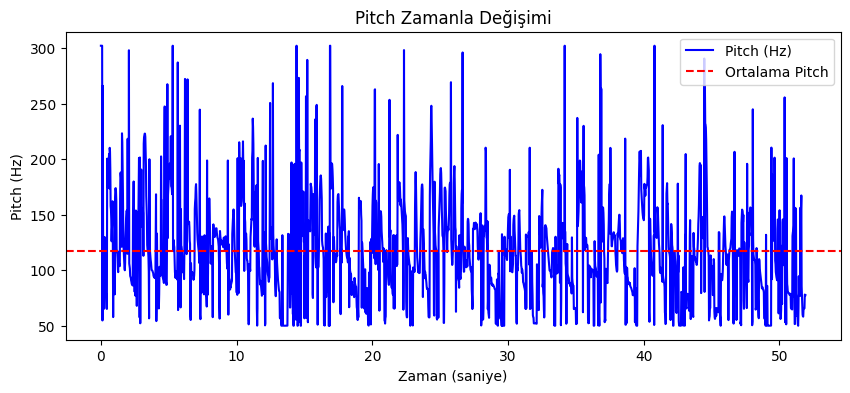

In [ ]:

# Zaman ekseni
frames = range(len(pitch_values))
t = librosa.frames_to_time(frames, sr=sr)

# Pitch grafiği
plt.figure(figsize=(10, 4))
plt.plot(t, pitch_values, label="Pitch (Hz)", color="blue")
plt.axhline(y=pitch_mean, color='red', linestyle='--', label="Ortalama Pitch")
plt.title("Pitch Zamanla Değişimi")
plt.xlabel("Zaman (saniye)")
plt.ylabel("Pitch (Hz)")
plt.legend()
plt.show()

*Sonuçların Yorumu*
- Pitch Variation Düşükse (örneğin, < 0.1):
> Monoton bir konuşma, tonlama değişiklikleri çok az.
Diksiyon için öneri: Daha fazla vurgu ve tonlama değişimi kullanılması gerekebilir.





- Pitch Variation Yüksekse (örneğin, > 0.3):
> Daha dinamik ve etkileyici bir konuşma.
Ancak aşırı yüksek pitch variation, dikkat dağınıklığına veya diksiyon problemlerine yol açabilir.

*Ortalama Pitch Seviyesi:*

Erkek sesleri
genelde 100-150 Hz, kadın sesleri ise 200-300 Hz arasında olur. Bu değerleri kontrol ederek ses tonunun genel uyumunu analiz edebilirsiniz.

In [ ]:
# Sessiz alanları çıkararak pitch analizi
non_silent_intervals = librosa.effects.split(y, top_db=30)
y_non_silent = np.concatenate([y[start:end] for start, end in non_silent_intervals])

# Sessiz alanlar hariç pitch hesaplama
pitch_values_non_silent = librosa.yin(y_non_silent, fmin=50, fmax=300, sr=sr)
pitch_mean_ns = np.mean(pitch_values_non_silent)
pitch_std_ns = np.std(pitch_values_non_silent)
pitch_variation_ns = pitch_std_ns / pitch_mean_ns
print(f"Pitch Varyasyonu (Sessiz Alanlar Hariç): {pitch_variation_ns:.2f}")


Pitch Varyasyonu (Sessiz Alanlar Hariç): 0.38


***MFCC (Mel-Frequency Cepstral Coefficients)***
>MFCC, bir ses sinyalinin spektral özelliklerini temsil eden bir dizi katsayıdır. İnsan kulağının duyma aralığına uygun olarak frekans bileşenlerini analiz eder.

In [ ]:
y, sr = librosa.load(audio_path)

# MFCC hesapla
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 MFCC katsayısı

# MFCC ortalamasını hesapla
mfcc_mean = np.mean(mfcc, axis=1)  # Her bir MFCC katsayısının ortalaması
print(f"MFCC Ortalama Değerleri: {mfcc_mean}")

MFCC Ortalama Değerleri: [-193.41275    110.70685    -18.234179    56.588093    -7.733061
   21.655287   -23.003098    -3.4776597  -16.361664    -4.2136564
   -6.3340387   -9.932842     6.600432 ]


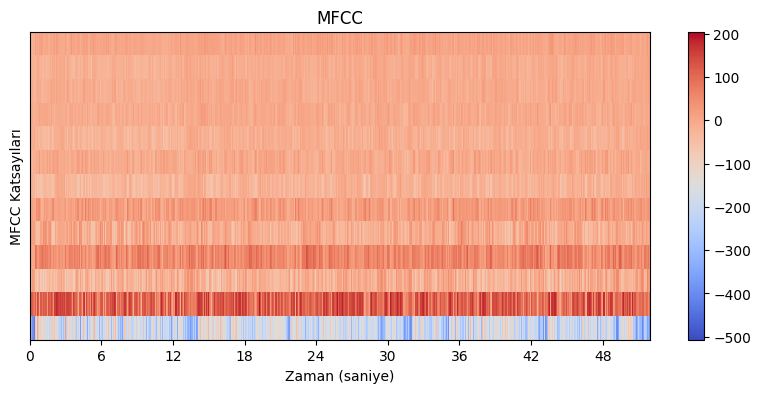

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title("MFCC")
plt.xlabel("Zaman (saniye)")
plt.ylabel("MFCC Katsayıları")
plt.show()

***ZCR (Zero-Crossing Rate)***
>ZCR, ses sinyalinin zaman alanında sıfır noktalarını kaç kez geçtiğini ölçer. Daha gürültülü veya tiz bir sinyal genellikle daha yüksek bir ZCR değerine sahiptir.

In [ ]:
# ZCR hesapla
zcr = librosa.feature.zero_crossing_rate(y)

# Ortalama ZCR
zcr_mean = np.mean(zcr)
print(f"Ortalama ZCR: {zcr_mean}")

Ortalama ZCR: 0.11231320022630756


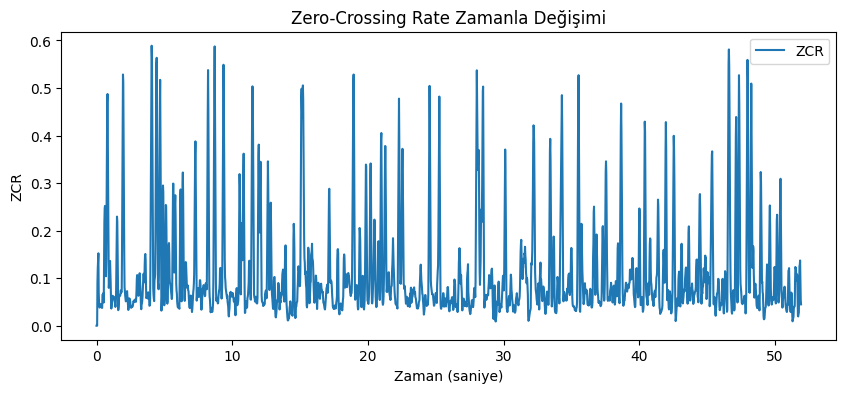

In [ ]:
# Zaman ekseni
frames = range(len(zcr[0]))
t = librosa.frames_to_time(frames, sr=sr)

plt.figure(figsize=(10, 4))
plt.plot(t, zcr[0], label="ZCR")
plt.title("Zero-Crossing Rate Zamanla Değişimi")
plt.xlabel("Zaman (saniye)")
plt.ylabel("ZCR")
plt.legend()
plt.show()